In [ ]:
import sys
import os

local_path='/Users/adrianhernandez/JPL_2021/'
sys.path.append(local_path + 'MulensModel_master/source')

In [ ]:
import numpy as np

import matplotlib.pyplot as pl
import numpy as np
import scipy.optimize as op
import astropy.units as u
from scipy.stats import chisquare
from datetime import datetime
from astropy.coordinates import SkyCoord
import pandas as pd
from scipy import stats
import MulensModel as mm
from MulensModel.utils import Utils
import mcmcFit as mcfit

In [ ]:
#reading in data and loading it as arrays 

from glob import glob
im_dir = '/Users/adrianhernandez/JPL_2021/ukirt_psf/'
ukirt_file = glob(f"{im_dir}/*P71224*.txt")

#print(ukirt_file[2])

filename = ukirt_file[2][44:64]
ukirt_data_H = np.loadtxt(ukirt_file[0], usecols=range(3)) #H band data 
ukirt_data_K = np.loadtxt(ukirt_file[2], usecols=range(3)) # K band data 
H_data = mm.MulensData(file_name=ukirt_file[0]) #used only for the mulens code 
K_data = mm.MulensData(file_name=ukirt_file[2]) #used only for the mulens code
print(filename)

data = np.concatenate((ukirt_data_H,ukirt_data_K)) # combining both bands
print(len(data))

In [ ]:
# ***Set time range of planetary perturbation (including 2450000).***
(t_planet_start, t_planet_stop) = (2458660.,2458690.)

# ***Set time range of planetary perturbation (including 2450000).***

# *Set the magnification methods for the planet model*
# VBBL method will be used between t_planet_start and t_planet_stop, 
# and point_source_point_lens will be used everywhere else.
magnification_methods = [0, 'point_source_point_lens', 
    t_planet_start, 'VBBL', t_planet_stop, 
    'point_source_point_lens', 2459000.]

In [ ]:
## np.set_printoptions(threshold=sys.maxsize)

#Define fitting functions

def chi2_fun(theta, event, parameters_to_fit):
    """                                                                         
    Chi2 function. Changes values of the parameters and recalculates chi2.
    
    event = a MulensModel.Event
    parameters_to_fit = list of names of parameters to be changed
    theta = values of the corresponding parameters
    """
    # key = the name of the MulensModel parameter
    for (index, key) in enumerate(parameters_to_fit):
        if (key == 't_E' or key =='rho') and theta[index] < 0.:
            return np.inf 
        setattr(event.model.parameters, key, theta[index])
    return event.get_chi2(fit_blending = True)

def fit_model(event, parameters_to_fit):
    """
    Fit an "event" with "parameters_to_fit" as free parameters.
    
    event = a MulensModel event
    parameters_to_fit = list of parameters to fit
    """
    # Take the initial starting point from the event.
    x0 = []
    for key in parameters_to_fit:
        value = getattr(event.model.parameters, key)
        if isinstance(value, u.Quantity):
            x0.append(value.value)
        else:
            x0.append(value)

    # *Execute fit using a 'Nelder-Mead' algorithm*
    result = op.minimize(
        chi2_fun, x0=x0, args=(event, parameters_to_fit),
        method='Nelder-Mead')

    return result

In [164]:
# Using the Point Lens fit as input, search for a planetary solution
#
# Grid parameters: s (log), q (log)
# Fit parameters: rho, alpha
# PSPL parameters: t_0, u_0, t_E
#

# *Define the grid*
delta_log_s = 0.005
delta_log_q = 0.05
# grid_log_s = np.hstack(
#     (np.arange(
#         np.log10(0.1) - .1, np.log10(0.8) + 0.1, delta_log_s),
#     np.arange(
#         np.log10(1.2) - 0.1, np.log10(1.2) + 0.1, delta_log_s)))
grid_log_s = np.arange(np.log10(.6),np.log10(1.5),delta_log_s)
grid_log_q = np.arange(-5, -1, delta_log_q)

print(grid_log_s)
print(grid_log_q)

[-0.22184875 -0.21684875 -0.21184875 -0.20684875 -0.20184875 -0.19684875
 -0.19184875 -0.18684875 -0.18184875 -0.17684875 -0.17184875 -0.16684875
 -0.16184875 -0.15684875 -0.15184875 -0.14684875 -0.14184875 -0.13684875
 -0.13184875 -0.12684875 -0.12184875 -0.11684875 -0.11184875 -0.10684875
 -0.10184875 -0.09684875 -0.09184875 -0.08684875 -0.08184875 -0.07684875
 -0.07184875 -0.06684875 -0.06184875 -0.05684875 -0.05184875 -0.04684875
 -0.04184875 -0.03684875 -0.03184875 -0.02684875 -0.02184875 -0.01684875
 -0.01184875 -0.00684875 -0.00184875  0.00315125  0.00815125  0.01315125
  0.01815125  0.02315125  0.02815125  0.03315125  0.03815125  0.04315125
  0.04815125  0.05315125  0.05815125  0.06315125  0.06815125  0.07315125
  0.07815125  0.08315125  0.08815125  0.09315125  0.09815125  0.10315125
  0.10815125  0.11315125  0.11815125  0.12315125  0.12815125  0.13315125
  0.13815125  0.14315125  0.14815125  0.15315125  0.15815125  0.16315125
  0.16815125  0.17315125]
[-5.   -4.95 -4.9  -4.85 

In [ ]:
alpha_new = -9

In [ ]:
# For each grid point, fit for rho, alpha
grid = np.empty((5, len(grid_log_s) * len(grid_log_q)))
i = 0
print('{0:>12} {1:>6} {2:>7} {3:>7} {4:>7}'.format('chi2', 's', 'q', 'alpha', 'rho'))
for log_s in grid_log_s:
    for log_q in grid_log_q:
        # The major and minor images are on opposite sides of the lens:
        if log_s < 0.:
            alpha = alpha_new + 180.
        else:
            alpha = alpha_new
            
        # Define the Model and Event
        planet_model = mm.Model({
            't_0': 2458654.0, 
            'u_0': 0.03,
            't_E': 50.0,
            'rho': 10**(-2),
            's': 10.**log_s,
            'q': 10.**log_q,
            'alpha': alpha})
        planet_model.set_magnification_methods(magnification_methods)
        planet_event = mm.Event(datasets = [H_data,K_data], model=planet_model)
            
        # Fit the Event
        result = fit_model(planet_event, parameters_to_fit=['rho', 'alpha'])
        if result.success:
            chi2 = planet_event.get_chi2()
        else:
            chi2 = np.inf
                
        # Print and store result of fit
        print('{0:12.2f} {1:6.4f} {2:7.5f} {3:7.2f} {4:7.5f}'.format(
            chi2, 10.**log_s, 10.**log_q, 
            planet_event.model.parameters.alpha, planet_event.model.parameters.rho))
        
        grid[0, i] = log_s
        grid[1, i] = log_q
        grid[2, i] = chi2
        grid[3, i] = planet_event.model.parameters.alpha.value
        grid[4, i] = planet_event.model.parameters.rho      
        i += 1

In [ ]:
index_best = np.argmin(np.array(grid[2,:]))
index_sorted = np.argsort(np.array(grid[2,:]))

In [ ]:
# Plot the grid

n_best = 8 
colors = ['magenta', 'green', 'cyan','yellow','blue', 'red','orange']
if len(colors) < n_best - 1:
    raise ValueError('colors must have at least n_best -1 entries.')

# Plot the grid

fig, axes = pl.subplots(nrows=1, ncols=2,figsize=(10,10))
n_plot = 0
for i in np.arange(2):
    if i == 0:
        index_logs = np.where(grid_log_s < 0.)[0]
        index_grid = np.where(grid[0, :] < 0.)[0]
    else:
        index_logs = np.where(grid_log_s >= 0.)[0]
        index_grid = np.where(grid[0, :] >= 0.)[0]
    
    # Plot chi2 map

    chi2 = np.transpose(
            grid[2, index_grid].reshape(len(index_logs), len(grid_log_q)))
    
    im = axes[i].imshow(
        chi2, aspect='auto', origin='lower',
        extent=[
            np.min(grid_log_s[index_logs]) - delta_log_s , 
            np.max(grid_log_s[index_logs]) + delta_log_s ,
            np.min(grid_log_q) - delta_log_q, 
            np.max(grid_log_q) ],
        cmap='gray', 
        vmin=np.min(grid[2,:]), vmax=np.nanmax(grid[2,np.isfinite(grid[2,:])]))  
    
    # Mark best values: best="X", other good="o"
    if index_best in index_grid:
        axes[i].scatter(grid[0, index_best], grid[1, index_best], marker='x', color='white')
    for j, index in enumerate(index_sorted[1:n_best]):
        if index in index_grid:
            axes[i].scatter(grid[0, index], grid[1, index], marker='o', color=colors[j - 1])
            
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.text(0.5, 0.92, r'$\chi^2$ Map', ha='center')
fig.text(0.5, 0.04, 'log s', ha='center')
fig.text(0.04, 0.5, 'log q', va='center', rotation='vertical')
fig.text(1.1, 0.5, r'$\chi^2$', va='center', rotation='vertical')
pl.savefig('grid.png', format='png', dpi=1200,orientation='landscape')
pl.show()

In [ ]:
def make_grid_model(index):
    """
    Define a Model using the gridpoint information + the PSPL parameters.
    
    index = index of the grid point for which to generate the model
    """
    model = mm.Model({
        't_0': planet_event.model.parameters.t_0, 
        'u_0': planet_event.model.parameters.u_0,
        't_E': planet_event.model.parameters.t_E,
        'rho': grid[4, index],
        's': 10.**grid[0, index],
        'q': 10.**grid[1, index],
        'alpha': grid[3, index]})
    model.set_magnification_methods(magnification_methods)
    model_event = mm.Event(datasets = [H_data,K_data], model=model)
    return model

In [ ]:
# Plot the best-fit model
best_fit_model = make_grid_model(index_best)
print('Best Models')
print(best_fit_model)

best_fit_event = mm.Event(datasets=[H_data,K_data], model=best_fit_model)
(f_source, f_blend) = best_fit_event.get_ref_fluxes(fit_blending = True)

# # Whole model
# t_range_whole = [best_fit_model.parameters.t_0 - 5. * best_fit_model.parameters.t_E,
#                  best_fit_model.parameters.t_0 + 5. * best_fit_model.parameters.t_E]
pl.figure(figsize=(10,10))
best_fit_event.plot_model(t_range = [2457900,2458800],subtract_2450000=True, color='black')
best_fit_event.plot_data(subtract_2450000=True)
pl.title(filename + ' Grid model ')
#pl.savefig(filename + '_grid_model', dpi=100)
pl.show()

# Zoom of planet
# Best model = black
pl.figure(figsize=(10,10))
best_fit_event.plot_model(subtract_2450000=True, color='black',label='best',zorder=10)
best_fit_event.plot_data(subtract_2450000=True, s=5, zorder=10)
pl.xlim(8600,8725)
pl.title(filename + ' grid model zoom')
#pl.savefig(filename + '_grid_model_zoom', dpi=100)
pl.show()

pl.figure(figsize=(10,10))
best_fit_event.plot_residuals(show_errorbars=True,subtract_2450000=True)
pl.xlim(8600,8725)
pl.ylim(-.2,.2)
pl.title(filename + ' grid model residuals')
#pl.savefig(filename + '_grid_model_res', dpi=100)
pl.show()

# Other models (color-coding matches grid)
for j, index in enumerate(index_sorted[1:n_best]):
    model = make_grid_model(index)
    pl.figure(figsize=(10,10))
    model.plot_lc( f_source=f_source, f_blend=f_blend,
        subtract_2450000=True, color=colors[j - 1], lw=2)
    best_fit_event.plot_data(subtract_2450000=True, s=10, zorder=0,marker_list = 'o',markerfacecolor='none')
    pl.title('{0} best models'.format(n_best))
    pl.xlim(8640,8685)
    pl.legend(loc='best')
    #print('chi2: {0}'.format(model_event.get_chi2(fit_blending=True)))
    pl.show()
    print(model)
    

# for i, index in enumerate(index_sorted[1:n_best]):
#     model.plot_trajectory(color='blue', caustics=True)
#     #pl.xlim(-.05,.3)
#     #pl.ylim(-.10,.10)    
#     pl.show()

In [ ]:
#create a smaller grid around the best fit solutions for q and s leaving all parameters open 

#best fit for s < 1 = 0.89774
#other soltutions were are around 1.2 - 1.3 
#all q solutions are between 1.0-7.0*10^(-2)


In [ ]:
np.log10(0.89774) +.03

In [ ]:
# Using the Point Lens fit as input, search for a planetary solution
#
# Grid parameters: s (log), q (log)
# Fit parameters: rho, alpha
# PSPL parameters: t_0, u_0, t_E
#

# *Define the grid*
del_log_s = 0.002
del_log_q = 0.0167
#small fine grid set around solutions
small_grid_log_s = np.hstack(
    (np.arange(
        np.log10(0.89774) - .03, np.log10(0.89774) + 0.03, del_log_s),
    np.arange(
        np.log10(1.2) - 0.03, np.log10(1.2) + 0.03, del_log_s)))
#small fine grid set around solutions 
small_grid_log_q = np.arange(-2, -1, del_log_q)

print(small_grid_log_s)
print(small_grid_log_q)

In [ ]:
fit_alpha = -10.99199

In [ ]:
# For each grid point, fit for rho, alpha
small_grid = np.empty((8, len(small_grid_log_s) * len(small_grid_log_q)))
i = 0
print('{0:>12} {1:>6} {2:>7} {3:>7} {4:>7} {5:>7} {6:>7} {7:>7}'.format('chi2','s','q','t_0','u_0','t_E','alpha', 'rho'))
for new_log_s in small_grid_log_s:
    for new_log_q in small_grid_log_q:
        # The major and minor images are on opposite sides of the lens:
        if new_log_s < 0.:
            new_alpha = fit_alpha + 180.
        else:
            new_alpha = fit_alpha
            
        # Define the Model and Event
        full_model = mm.Model({
            't_0': 2458653.5, 
            'u_0': 0.041189,
            't_E': 43.3,
            'rho': 0.01887,
            's': 10.**new_log_s,
            'q': 10.**new_log_q,
            'alpha': new_alpha})
        full_model.set_magnification_methods(magnification_methods)
        full_event = mm.Event(datasets = [H_data,K_data], model=full_model)
            
        # Fit the Event
        result = fit_model(full_event, parameters_to_fit=['t_0','u_0','t_E','rho', 'alpha'])
        if result.success:
            chi_2 = full_event.get_chi2()
        else:
            chi_2 = np.inf
                
        # Print and store result of fit
        print('{0:12.2f} {1:6.4f} {2:7.5f} {3:7.2f} {4:7.5f} {5:7.5f} {6:7.5f} {7:7.5f}'.format(
            chi_2, 10.**new_log_s, 10.**new_log_q, 
            full_event.model.parameters.t_0,full_event.model.parameters.u_0,full_event.model.parameters.t_E,
            full_event.model.parameters.alpha, full_event.model.parameters.rho))
        
        small_grid[0, i] = new_log_s
        small_grid[1, i] = new_log_q
        small_grid[2, i] = chi_2
        small_grid[3, i] = full_event.model.parameters.alpha.value
        small_grid[4, i] = full_event.model.parameters.rho
        small_grid[5, i] = full_event.model.parameters.t_0
        small_grid[6, i] = full_event.model.parameters.u_0
        small_grid[7, i] = full_event.model.parameters.t_E
        i += 1

In [ ]:
new_index_best = np.argmin(np.array(small_grid[2,:]))
new_index_sorted = np.argsort(np.array(small_grid[2,:]))

# Plot the grid

n_best = 8 
colors = ['magenta', 'green', 'cyan','yellow','blue', 'red','orange']
if len(colors) < n_best - 1:
    raise ValueError('colors must have at least n_best -1 entries.')

# Plot the grid

fig, axes = pl.subplots(nrows=1, ncols=2,figsize=(10,10))
n_plot = 0
for i in np.arange(2):
    if i == 0:
        new_index_logs = np.where(small_grid_log_s < 0.)[0] ##change
        new_index_grid = np.where(small_grid[0, :] < 0.)[0] ##change 
    else:
        new_index_logs = np.where(small_grid_log_s >= 0.)[0]
        new_index_grid = np.where(small_grid[0, :] >= 0.)[0]
    
    # Plot chi2 map

    chi_2 = np.transpose(
            grid[2, new_index_grid].reshape(len(new_index_logs), len(small_grid_log_q)))
    
    im = axes[i].imshow(
        chi_2, aspect='auto', origin='lower',
        extent=[
            np.min(small_grid_log_s[new_index_logs]) - del_log_s/2 , 
            np.max(small_grid_log_s[new_index_logs]) + del_log_s/2 ,
            np.min(small_grid_log_q) - del_log_q/2, 
            np.max(small_grid_log_q)/2 ],
        cmap='gray', 
        vmin=np.min(small_grid[2,:]), vmax=np.nanmax(small_grid[2,np.isfinite(small_grid[2,:])]))  
    
    # Mark best values: best="X", other good="o"
    if new_index_best in new_index_grid:
        axes[i].scatter(small_grid[0, new_index_best], small_grid[1, new_index_best], marker='x', color='white')
    for j, new_index in enumerate(new_index_sorted[1:n_best]):
        if new_index in new_index_grid:
            axes[i].scatter(small_grid[0, new_index], small_grid[1, new_index], marker='o', color=colors[j - 1])
            
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.text(0.5, 0.92, r'$\chi^2$ Map', ha='center')
fig.text(0.5, 0.04, 'log s', ha='center')
fig.text(0.04, 0.5, 'log q', va='center', rotation='vertical')
fig.text(1.1, 0.5, r'$\chi^2$', va='center', rotation='vertical')
#pl.savefig('grid.png', format='png', dpi=1200,orientation='landscape')
pl.show()

In [ ]:
def new_grid_model(new_index):
    """
    Define a Model using the gridpoint information + the PSPL parameters.
    
    index = index of the grid point for which to generate the model
    """
    new_model = mm.Model({
        't_0': small_grid[5, new_index], 
        'u_0': small_grid[6, new_index],
        't_E': small_grid[7, new_index],
        'rho': small_grid[4, new_index],
        's': 10.**small_grid[0, new_index],
        'q': 10.**small_grid[1, new_index],
        'alpha': small_grid[3, new_index]})
    new_model.set_magnification_methods(magnification_methods)
    new_model_event = mm.Event(datasets = [H_data,K_data], model=new_model)
    return new_model

In [ ]:
# Plot the best-fit model
best_model = new_grid_model(new_index_best)
print('Best Models')
print(best_model)


best_event = mm.Event(datasets=[H_data,K_data], model=best_model)
(f_source, f_blend) = best_event.get_ref_fluxes(fit_blending = True)

print('chi2: {0}'.format(best_event.get_chi2()))

# # Whole model
# t_range_whole = [best_fit_model.parameters.t_0 - 5. * best_fit_model.parameters.t_E,
#                  best_fit_model.parameters.t_0 + 5. * best_fit_model.parameters.t_E]
pl.figure(figsize=(10,10))
best_event.plot_model(t_range = [2457900,2458800],subtract_2450000=True, color='black')
best_event.plot_data(subtract_2450000=True)
pl.title(filename + ' Grid model ')
#pl.savefig(filename + '_grid_model', dpi=100)
pl.show()

# Zoom of planet
# Best model = black
pl.figure(figsize=(10,10))
best_event.plot_model(subtract_2450000=True, color='black',label='best',zorder=10)
best_event.plot_data(subtract_2450000=True, s=5, zorder=10)
pl.xlim(8600,8725)
#pl.title(filename + ' grid model zoom')
#pl.savefig(filename + '_grid_model_zoom', dpi=100)
pl.show()

pl.figure(figsize=(10,10))
best_event.plot_residuals(show_errorbars=True,subtract_2450000=True)
pl.xlim(8600,8725)
pl.ylim(-.2,.2)
pl.title(filename + ' grid model residuals')
#pl.savefig(filename + '_grid_model_res', dpi=100)
pl.show()

# Other models (color-coding matches grid)
for j, new_index in enumerate(new_index_sorted[1:n_best]):
    new_model = new_grid_model(new_index)
    pl.figure(figsize=(10,10))
    new_model.plot_lc(subtract_2450000=True, color=colors[j - 1], lw=2)
    best_event.plot_data(subtract_2450000=True, s=10, zorder=0,marker_list = 'o',markerfacecolor='none')
    pl.title('{0} best models'.format(n_best))
    pl.xlim(8640,8685)
    pl.legend(loc='best')
    #print('chi2: {0}'.format(model_event.get_chi2(fit_blending=True)))
    pl.show()
    print(new_model)

In [ ]:
# Refine the n_best minima to get the best-fit solution
parameters_to_fit = ['t_0', 'u_0', 't_E', 'rho', 'alpha', 's', 'q'] #mcmc

fits = []
for new_index in new_index_sorted[:n_best]:
    new_model = new_grid_model(new_index)
    event = mm.Event(datasets=[H_data,K_data], model=new_model)
    print(event.model)
    result = fit_model( 
        event, parameters_to_fit=parameters_to_fit)
    fits.append([result.fun, result.x])
    print(result)

    t_0 (HJD)       u_0    t_E (d)     rho         s            q alpha (deg) 
2458653.51960  0.024524    68.0967 0.01322   0.91856   0.06994221   105.28001 

chi2: 1950.189675322832


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/MulensModel-1.17.15-py3.8-macosx-10.9-x86_64.egg/MulensModel/model.py:453: FutureWarning: Keyword "marker_list" is deprecated. Use MulensData.plot_properties instead.
  warnings.warn('Keyword "' + old_keyword + '" is deprecated.' +


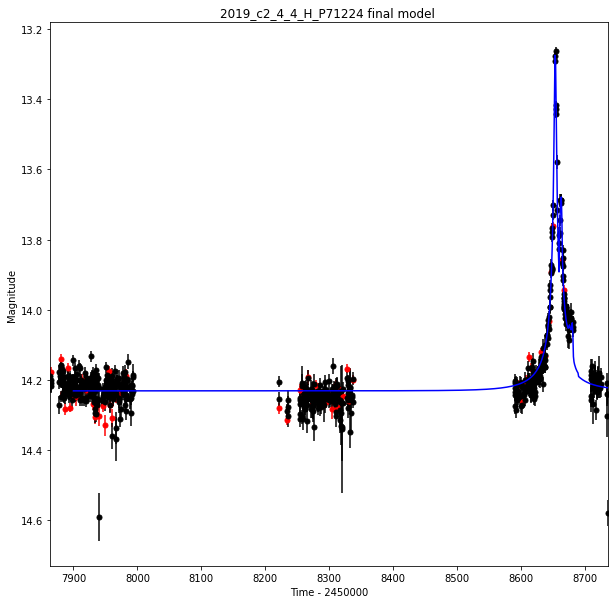

[46.60512218] 1234.540066714243


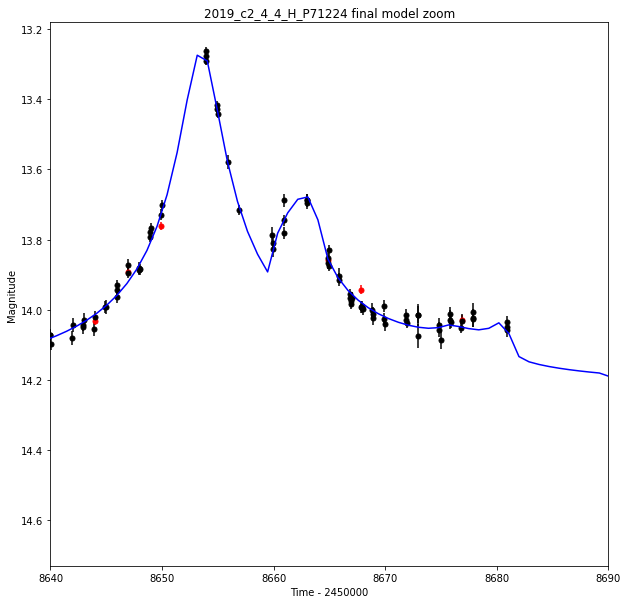

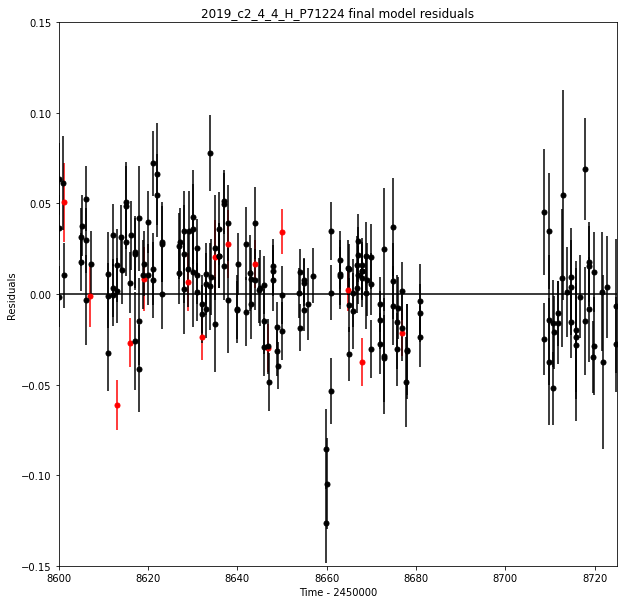

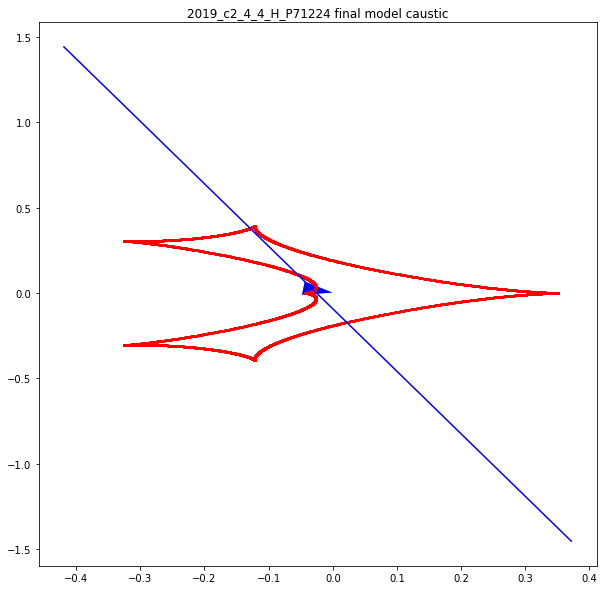

In [163]:
# Plot the best-fit model and output the parameters

# Extract best fit
chi_2 = [x[0] for x in fits]
fit_parameters = [x[1] for x in fits]
new_index_best = np.argmin(chi_2)

# Setup the model and event
parameters = {}
for i, parameter in enumerate(parameters_to_fit):
    parameters[parameter] = fit_parameters[new_index_best][i]
    
final_model = mm.Model(parameters)
final_model.set_magnification_methods(magnification_methods)
final_event = mm.Event(datasets=[H_data,K_data], model=final_model)
(f_source, f_blend) = final_event.get_ref_fluxes(fit_blending = True)
print(final_event.model)
print('chi2: {0}'.format(final_event.get_chi2()))

# t_range_whole = [best_fit_model.parameters.t_0 - 5. * best_fit_model.parameters.t_E,
#                  best_fit_model.parameters.t_0 + 5. * best_fit_model.parameters.t_E]

# # Plot the whole light curve
pl.figure(figsize=(10,10))
final_event.plot_data(subtract_2450000=True,marker_list ='o')
final_event.plot_model(t_range = [2457900,2458800],subtract_2450000=True, color='blue',zorder=10)
pl.title(filename + ' final model ')
#pl.savefig(filename + 'final_model', dpi=100)
pl.show()

print(f_source,f_blend)
# Plot zoom of the planet
pl.figure(figsize=(10,10))
final_event.plot_model(f_source = f_source, f_blend = f_blend,t_range = [2457900,2458800],subtract_2450000=True, color='blue', zorder=10)
final_event.plot_data(subtract_2450000=True)

pl.xlim(8640,8690)
pl.title(filename + ' final model zoom')
#pl.savefig(filename + '_final_model_zoom', dpi=100)
pl.show()

pl.figure(figsize=(10,10))
final_event.plot_residuals(show_errorbars=True,subtract_2450000=True)
pl.xlim(8600,8725)
pl.ylim(-.15,.15)
pl.title(filename + ' final model residuals')
#pl.savefig(filename + '_final_model_res', dpi=100)
pl.show()

pl.figure(figsize=(10,10))
final_event.plot_trajectory(color='blue', caustics=True)
pl.title(filename + ' final model caustic')
#pl.savefig(filename + '_final_model_caustic', dpi=100)
pl.show()